<a href="https://colab.research.google.com/github/atolia/colabs/blob/main/Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
try:
  import yfinance as yf
  import mibian
except Exception:
  !pip install yfinance > /dev/null 2>&1
  !pip install mibian >/dev/null
  import yfinance as yf
  import mibian
import pandas as pd
from google.colab import data_table
from datetime import datetime
import math
import numpy as np
# from types import SimpleNamespace
from IPython.display import Markdown, display, Javascript

def printmd(string):
    display(Markdown(string))

date_format = "%Y-%m-%d"
#@title Stock common info { vertical-output: true, display-mode: "form" }
symbol = "qyld" #@param {type:"string"}
ticker = yf.Ticker(symbol) 
distanceStrike =   6#@param {type:"integer"}
distanceDate =   6#@param {type:"integer"}
commissionUSD = 1.5 #@param {type:"number"}
hist1y = ticker.history(period='1y')
# ' '.join([prop for prop in ticker.info ])

def showPUTs(ticker, deltaLimit=-0.3 ):
  final = [];
  tdPrc = ticker.info['regularMarketPrice']
  ytdPrc = ticker.info['regularMarketPreviousClose']
  diff= (tdPrc-ytdPrc)/ytdPrc*100
  interest_rate = 0
  colsArr = [ 'days', 'Strike', 'today Change%', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
  for j in range(0, min(distanceDate, len(ticker.options)-1)):
    out = [];
    opdtstr = ticker.options[j]
    puts = ticker.option_chain(opdtstr).puts
    inMndx1 = puts.loc[puts['inTheMoney'] == True].index
    if len(inMndx1)>0:
      inMndx = inMndx1[0] 
    if inMndx < 1:
      continue
    opdt = datetime.strptime(opdtstr, date_format)
    # print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
    for i in range(max(0, (inMndx-distanceStrike-1)), inMndx):
      dysLeft = (opdt-datetime.now()).days+1
      if dysLeft < 2 or i == len(puts)-1:
        continue
      if puts.iloc[i].inTheMoney:
        continue
      prc = puts.iloc[i].bid or puts.iloc[i].lastPrice or puts.iloc[i].ask
      earnPerDay = round(prc/dysLeft*100, 2)
      OI = round(puts.iloc[i].openInterest, 2)
      IV = round(puts.iloc[i].impliedVolatility*100, 2)
      # p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
      p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

      profitUSD = prc*100 - commissionUSD
      profit = profitUSD/tdPrc
      change = 0 if math.isnan(puts.iloc[i].percentChange) else round(puts.iloc[i].percentChange)
      toAdd = [ dysLeft, puts.iloc[i].strike, change, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, p.putDelta, p.putDelta2, p.gamma]
      out.append(toAdd)
      final.append(toAdd)
    # display(pd.DataFrame(out, columns = colsArr ).round(2))

  # openInterest	impliedVolatility
  df = pd.DataFrame(final, columns = colsArr).sort_values(by=colsArr[6], ascending=False)
  df = df[df.Delta > deltaLimit]

  print()
  printmd(f" - Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%.")
  printmd(f"- Final list OutOfMoney PUTS for nearest {distanceStrike} Strikes and {distanceDate} Dates. Sorted by **1 year profit**. With Delta lower than **"+str(deltaLimit)+"**")
  yr = ticker.history(interval='1d', period='52wk')['Close']
  printmd(' - **1yr min:** ``$' + str(round((hist1y['Close'].min()), 2)) + '``' +
          ' **max:** ``$' + str(round((hist1y['Close'].max()), 2)) + '``' +
          ' **mean:** ``$' + str(round((hist1y['Close'].mean()), 2)) + '``' +
          ' **std:** ``$' + str(round((hist1y['Close'].std()), 2)) + '``' +
          ' **variance:** ' + str(round(hist1y['Close'].std()/hist1y['Close'].mean()*100, 2) ) + '%' 
          ' **Year by day Hist. Volatility:**'+ ' '+ str(round(yr.pct_change().std()*np.sqrt(365)*100,2))+'%')  
  return df


if len(ticker.get_splits()):
  printmd('**Splits:** ')
  ticker.get_splits()




In [12]:
#@title Best Puts to sell
df = showPUTs(yf.Ticker(symbol), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) # , min_width="500"

 - Prev.Day price 19.13, Current price **18.38**, diff: -3.92%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **-0.4**

 - **1yr min:** ``$18.38`` **max:** ``$21.47`` **mean:** ``$20.43`` **std:** ``$0.66`` **variance:** 3.24% **Year by day Hist. Volatility:** 20.74%

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
4,10,17.0,0,30.5,3.20,1.66,60.57,12.50,0,-0.00,0.00,0.00
9,38,18.0,0,58.5,1.58,3.18,30.57,1.56,0,-0.00,0.00,0.00
5,10,17.5,0,13.5,1.50,0.73,26.81,6.25,0,-0.00,0.00,0.00
6,10,18.0,0,13.5,1.50,0.73,26.81,3.13,0,-0.00,0.00,0.00
0,10,14.5,0,8.5,1.00,0.46,16.88,73.44,451,-0.02,0.03,0.02
2,10,15.5,0,8.5,1.00,0.46,16.88,96.09,21,-0.12,0.16,0.07
3,10,16.5,0,8.5,1.00,0.46,16.88,12.50,0,-0.00,0.00,0.00
16,101,17.5,0,78.5,0.79,4.27,15.43,3.13,0,-0.00,0.00,0.02
1,10,15.0,0,6.5,0.80,0.35,12.91,25.00,0,-0.00,0.00,0.00
8,38,17.0,0,18.5,0.53,1.01,9.67,6.25,0,-0.00,0.00,0.00


Dual Delta is like Delta but caclulated from Strike instead of StockPrice [More about Dual Delta ](http://jtoll.com/post/duel-of-the-deltas/)

**QQQ:**

In [6]:
#@title Best QQQ Puts to sell

df = showPUTs(yf.Ticker('QQQ'), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200)

 - Prev.Day price 309.25, Current price **297.15**, diff: -3.91%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **30**

 - **1yr min:** ``$18.38`` **max:** ``$21.47`` **mean:** ``$20.43`` **std:** ``$0.66`` **variance:** 3.24%- **Year by day Hist. Volatility:** 28.28%

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
6,3,297.0,0,598.5,200.00,2.01,245.05,0.20,0,-0.00,0.00,0.15
5,3,296.0,0,548.5,183.33,1.85,224.58,0.78,0,-0.00,0.00,0.00
4,3,295.0,0,510.5,170.67,1.72,209.02,1.56,0,-0.00,0.00,0.00
3,3,294.0,0,467.5,156.33,1.57,191.42,3.13,0,-0.00,0.00,0.00
2,3,293.0,0,445.5,149.00,1.50,182.41,3.13,0,-0.00,0.00,0.00
1,3,292.0,0,409.5,137.00,1.38,167.67,3.13,0,-0.00,0.00,0.00
0,3,291.0,0,404.5,135.33,1.36,165.62,6.25,0,-0.00,0.00,0.00
13,6,297.0,0,667.5,111.50,2.25,136.65,0.20,0,-0.02,0.02,0.75
12,6,296.0,0,619.5,103.50,2.08,126.83,0.78,0,-0.00,0.00,0.00
20,8,296.0,0,777.5,97.38,2.62,119.38,0.78,0,-0.00,0.00,0.00


**SPY:**

In [8]:
#@title Best SPY Puts to sell

df = showPUTs(yf.Ticker('SPY'), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) 

 - Prev.Day price 411.34, Current price **398.17**, diff: -3.2%.

- Final list OutOfMoney PUTS for nearest 6 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **30**

 - **1yr min:** ``$18.38`` **max:** ``$21.47`` **mean:** ``$20.43`` **std:** ``$0.66`` **variance:** 3.24% **Year by day Hist. Volatility:** 20.73%

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
6,3,398.0,0,596.5,199.33,1.50,182.27,0.20,0.0,-0.01,0.01,0.34
5,3,397.0,0,552.5,184.67,1.39,168.82,0.78,0.0,-0.00,0.00,0.00
4,3,396.0,0,509.5,170.33,1.28,155.69,1.56,0.0,-0.00,0.00,0.00
3,3,395.0,0,468.5,156.67,1.18,143.16,1.56,0.0,-0.00,0.00,0.00
2,3,394.0,0,454.5,152.00,1.14,138.88,3.13,0.0,-0.00,0.00,0.00
1,3,393.0,0,398.5,133.33,1.00,121.77,3.13,0.0,-0.00,0.00,0.00
0,3,392.0,0,385.5,129.00,0.97,117.80,3.13,0.0,-0.00,0.00,0.00
13,6,398.0,0,678.5,113.33,1.70,103.66,0.10,0.0,-0.00,0.00,0.03
12,6,397.0,0,634.5,106.00,1.59,96.94,0.78,0.0,-0.00,0.00,0.01
11,6,396.0,0,615.5,102.83,1.55,94.04,0.78,0.0,-0.00,0.00,0.00


Overal info:

In [ ]:
#@title INFO { vertical-output: true }
if  ticker.info.get('longName'):
  printmd('- **Name:** ' + ticker.info['longName'] )

printmd('- **Expiration dates:** '+' '.join([dt for dt in ticker.options ]) )
printmd('- **Country:** ' + getattr(ticker,'country', 'Unknown') +' **Sector:** ' + getattr(ticker,'sector', 'Unknown') + ' **Industry:** ' + getattr(ticker,'industry', 'Unknown') + ' **MarketCap:** ' + str(round( getattr(ticker,'marketCap', 0) /1000/1000/1000,2)) + "B" )

if  ticker.info.get('longBusinessSummary'):
  printmd('- **Summary:** ' + ticker.info['longBusinessSummary'] )
if  ticker.info.get('dividendYield'):
  printmd('- **dividendYield:** ' + str(round((ticker.info['dividendYield'] or 0)*100, 2)) + '%' + 
          ' **trailingAnnualDividendYield:** ' + str(round((ticker.info['trailingAnnualDividendYield'] or 0)*100, 2)) + '%' +
          ' **Frwd.dividend/yr:** ' + str(round((ticker.info['dividendRate'] or 0), 2)) + '$' )
  printmd('- **exDividendDate:** ' + datetime.strftime(datetime.fromtimestamp(ticker.info['exDividendDate'] or 0), date_format+' %Z'))
else:
  print('No dividends info available ')  
printmd('- **totalRevenue:** ' + str(round(getattr(ticker,'totalRevenue', 0)/1e9, 2)) + 'B' + ' **revenueGrowth:** ' + str(round(getattr(ticker,'revenueGrowth', 0)*100, 2)) + '%' + ' **grossMargins:** ' + str(round(getattr(ticker,'grossMargins',0)*100, 2)) + '%' + ' **ebitdaMargins:** ' + str(round(getattr(ticker,'ebitdaMargins',0)*100, 2)) + '%')
if  ticker.info.get('trailingEps'):
  printmd('- **trailingEps:** ' + str(round(ticker.info['trailingEps'], 2)) + '\$' + ' **forwardEps:** ' + str(round(ticker.info['forwardEps'], 4)) + '$')
else:
  print('No EPS')  
printmd('- **StockPrice:** ``$' + str(round(ticker.info['regularMarketPrice'], 2)) + '``' +
        ' **1yr min:** ``$' + str(round((hist1y['Close'].min()), 2)) + '``' +
        ' **max:** ``$' + str(round((hist1y['Close'].max()), 2)) + '``' +
        ' **mean:** ``$' + str(round((hist1y['Close'].mean()), 2)) + '``' +
        ' **std:** ``$' + str(round((hist1y['Close'].std()), 2)) + '``' +
        ' **variance:** ' + str(round(hist1y['Close'].std()/hist1y['Close'].mean()*100, 2) ) + '%' 
        )
if len(ticker.get_splits()):
  printmd('**Splits:** ')
  ticker.get_splits()
yr=ticker.history(interval='1d', period='52wk')['Close']
print('- year by day Hist. Volatil:', str(round(yr.pct_change().std()*np.sqrt(365)*100,2))+'%' )



- **Name:** Global X NASDAQ 100 Covered Call ETF

- **Expiration dates:** 2022-05-20 2022-06-17 2022-08-19 2022-11-18

- **Country:** Unknown **Sector:** Unknown **Industry:** Unknown **MarketCap:** 0.0B

- **Summary:** The fund will invest at least 80% of its total assets in the securities of the underlying index. The CBOE NASDAQ-100® BuyWrite Index is a benchmark index that measures the performance of a theoretical portfolio that holds a portfolio of the stocks included in the NASDAQ-100® Index, and "writes" (or sells) a succession of one-month at-the-money NASDAQ-100® Index covered call options. It is non-diversified.

No dividends info available 


- **totalRevenue:** 0.0B **revenueGrowth:** 0% **grossMargins:** 0% **ebitdaMargins:** 0%

No EPS


- **StockPrice:** ``$19.25`` **1yr min:** ``$18.72`` **max:** ``$21.47`` **mean:** ``$20.43`` **std:** ``$0.65`` **variance:** 3.18%

- year by day Hist. Volatil: 20.29%


In [ ]:
print('CALLS:')
# symbol = "PLTR" 
# # symbol = "VIPS" 
# ticker = yf.Ticker(symbol) 
# distanceStrike =   5 
# distanceDate =   6 


final = []; 
tdPrc = ticker.info['regularMarketPrice']
ytdPrc = ticker.info['regularMarketPreviousClose']
diff= (tdPrc-ytdPrc)/ytdPrc*100
interest_rate = 0
colsArr = [ 'days', 'Strike', 'Change%', 'ITM', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
for j in range(0, min(distanceDate, len(ticker.options)-1)):
  out = [];
  opdtstr = ticker.options[j]
  calls = ticker.option_chain(opdtstr).calls
  inMndx1 = calls.loc[calls['inTheMoney'] == True].index
  if len(inMndx1)>0:
     inMndx = inMndx1[-1] 
  if inMndx < 1:
    continue
  opdt = datetime.strptime(opdtstr, date_format)
  print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
  for i in range(inMndx, min(len(calls)-1, (inMndx+distanceStrike-1))):
    dysLeft = (opdt-datetime.now()).days+1
    # if dysLeft < 2:
    if dysLeft < 2 or calls.iloc[i].inTheMoney:
      continue
    prc = calls.iloc[i].bid or calls.iloc[i].lastPrice or calls.iloc[i].ask
    earnPerDay = round(prc/dysLeft*100, 2)
    OI = round(calls.iloc[i].openInterest, 2)
    IV = round(calls.iloc[i].impliedVolatility*100, 2)
    # p = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
    bs = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

    profitUSD = prc*100 - commissionUSD
    profit = profitUSD/tdPrc
    change = 0 if math.isnan(calls.iloc[i].percentChange) else round(calls.iloc[i].percentChange)
    toAdd = [ dysLeft, calls.iloc[i].strike, change, calls.iloc[i].inTheMoney, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, bs.callDelta, bs.callDelta2, bs.gamma]
    out.append(toAdd)
    final.append(toAdd)
  display(pd.DataFrame(out, columns = colsArr ).round(2))

# openInterest	impliedVolatility
df = pd.DataFrame(final, columns = colsArr)
print()
printmd(f" - Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%."+
        f" Final list ITM and OutOfMoney calls for nearest {distanceStrike} Strikes and {distanceDate} Dates")

# print('\n==== Total: =====')
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200  ) # , min_width="500"


CALLS:

   ========== Expiration date: 2022-05-20 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,21,15.0,-21,False,68.5,3.33,4.70,81.68,67.09,607,0.46,-0.40,0.17
1,21,16.0,-15,False,38.5,1.90,2.64,45.91,67.19,1318,0.31,-0.25,0.15
2,21,17.0,12,False,18.5,0.95,1.27,22.06,67.58,543,0.19,-0.15,0.12
3,21,18.0,-40,False,8.5,0.48,0.58,10.14,70.31,459,0.12,-0.09,0.08



   ========== Expiration date: 2022-06-17 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,49,15.0,-1,False,113.5,2.35,7.79,58.00,65.43,205,0.50,-0.41,0.11
1,49,16.0,-4,False,78.5,1.63,5.39,40.12,65.63,140,0.39,-0.31,0.11
2,49,17.0,-16,False,53.5,1.12,3.67,27.34,66.41,52,0.30,-0.23,0.10
3,49,18.0,-8,False,38.5,0.82,2.64,19.68,67.58,67,0.23,-0.16,0.08



   ========== Expiration date: 2022-08-19 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,112,15.0,-12,False,173.5,1.56,11.90,38.79,62.84,459,0.54,-0.40,0.08
1,112,16.0,0,False,138.5,1.25,9.50,30.97,62.50,153,0.46,-0.33,0.08
2,112,17.0,-10,False,108.5,0.98,7.44,24.26,63.28,670,0.40,-0.27,0.08
3,112,18.0,0,False,83.5,0.76,5.73,18.67,63.09,221,0.33,-0.22,0.07



   ========== Expiration date: 2022-11-18 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,203,15.0,0,False,233.5,1.16,16.02,28.8,61.28,309,0.57,-0.39,0.06
1,203,16.0,-4,False,203.5,1.01,13.96,25.1,62.06,500,0.51,-0.33,0.06
2,203,17.0,0,False,173.5,0.86,11.90,21.4,62.26,63,0.46,-0.29,0.06
3,203,18.0,0,False,143.5,0.71,9.85,17.7,61.47,277,0.41,-0.25,0.06


 - Prev.Day price 14.95, Current price **14.58**, diff: -2.5%. Final list ITM and OutOfMoney calls for nearest 6 Strikes and 6 Dates

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,21,15.0,-21,False,68.5,3.33,4.70,81.68,67.09,607,0.46,-0.40,0.17
1,21,16.0,-15,False,38.5,1.90,2.64,45.91,67.19,1318,0.31,-0.25,0.15
2,21,17.0,12,False,18.5,0.95,1.27,22.06,67.58,543,0.19,-0.15,0.12
3,21,18.0,-40,False,8.5,0.48,0.58,10.14,70.31,459,0.12,-0.09,0.08
4,49,15.0,-1,False,113.5,2.35,7.79,58.00,65.43,205,0.50,-0.41,0.11
5,49,16.0,-4,False,78.5,1.63,5.39,40.12,65.63,140,0.39,-0.31,0.11
6,49,17.0,-16,False,53.5,1.12,3.67,27.34,66.41,52,0.30,-0.23,0.10
7,49,18.0,-8,False,38.5,0.82,2.64,19.68,67.58,67,0.23,-0.16,0.08
8,112,15.0,-12,False,173.5,1.56,11.90,38.79,62.84,459,0.54,-0.40,0.08
9,112,16.0,0,False,138.5,1.25,9.50,30.97,62.50,153,0.46,-0.33,0.08


In [ ]:
# @ title Print option chain { run: "auto" }
nearOdate=ticker.options[0]
date = "" 
 # @ param {type:"string"}
opt = ticker.option_chain(date or nearOdate)
# opts=opt[0]
# hf=int(len(opts)/2)
# inM=opts.loc[opts['inTheMoney'] ] # == True
# inMndx=opts.loc[opts['inTheMoney'] == True].index[0] 
# if inMndx<=distanceStrike:
  # distanceStrike = inMndx
# df1=opts.iloc[inMndx-distanceStrike:inMndx+distanceStrike].style.hide_index()
# df1.set_table_styles( [{'selector': 'tr:hover',   'props': [('background-color', 'yellow')]}] )
# opts.style.background_gradient()
# opts.round(2)
# pp=opts.round({"strike":1, "lastPrice":2, "bid":3, "ask":4})
# data_table.DataTable(opts[['strike','lastPrice','impliedVolatility','inTheMoney']].round(2), 
#                      include_index=False, num_rows_per_page=200  ) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Calls')
display(data_table.DataTable(opt[0].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Puts')
display(data_table.DataTable(opt[1].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"

# .style.hide_index().background_gradient(cmap='coolwarm', subset='impliedVolatility')


Exp date: 2022-04-14
Calls


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,UL220414C00030000,2022-03-23 14:51:33+00:00,30.0,15.00,15.50,15.70,0.00,0.00,7.0,10,2.20,True,REGULAR,USD
1,UL220414C00032500,2022-03-21 14:25:35+00:00,32.5,12.60,12.90,13.20,0.00,0.00,NaN,9,1.66,True,REGULAR,USD
2,UL220414C00035000,2022-04-08 13:30:32+00:00,35.0,10.80,10.40,10.70,0.00,0.00,1.0,1,1.34,True,REGULAR,USD
3,UL220414C00037500,2022-03-07 16:00:00+00:00,37.5,6.70,8.30,8.60,0.00,0.00,59.0,105,1.65,True,REGULAR,USD
4,UL220414C00040000,2022-03-09 16:38:52+00:00,40.0,6.00,6.00,6.20,0.00,0.00,3.0,68,1.37,True,REGULAR,USD
5,UL220414C00042500,2022-04-04 15:34:21+00:00,42.5,3.90,3.00,3.20,0.00,0.00,3.0,459,0.52,True,REGULAR,USD
6,UL220414C00045000,2022-04-11 18:47:29+00:00,45.0,0.84,0.75,0.85,-0.33,-28.21,231.0,816,0.31,True,REGULAR,USD
7,UL220414C00047500,2022-04-11 18:33:43+00:00,47.5,0.10,0.05,0.10,0.00,0.00,13.0,1161,0.35,False,REGULAR,USD
8,UL220414C00050000,2022-04-08 19:40:07+00:00,50.0,0.05,0.00,0.05,0.00,0.00,1.0,1221,0.54,False,REGULAR,USD
9,UL220414C00052500,2022-04-11 16:19:09+00:00,52.5,0.06,0.00,0.05,0.01,20.00,5.0,171,0.66,False,REGULAR,USD


Exp date: 2022-04-14
Puts


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,UL220414P00035000,2022-04-05 13:51:47+00:00,35.0,0.03,0.0,0.15,0.00,0.00,5.0,11,1.37,False,REGULAR,USD
1,UL220414P00037500,2022-03-29 19:12:35+00:00,37.5,0.03,0.0,0.05,0.00,0.00,11.0,170,0.88,False,REGULAR,USD
2,UL220414P00040000,2022-04-07 17:56:13+00:00,40.0,0.02,0.0,0.10,0.00,0.00,7.0,254,0.70,False,REGULAR,USD
3,UL220414P00042500,2022-04-11 13:50:57+00:00,42.5,0.05,0.0,0.05,0.00,0.00,1.0,1153,0.42,False,REGULAR,USD
4,UL220414P00045000,2022-04-11 18:07:44+00:00,45.0,0.25,0.2,0.30,0.01,4.17,98.0,1176,0.27,False,REGULAR,USD
5,UL220414P00047500,2022-04-11 16:35:28+00:00,47.5,2.05,1.9,2.10,0.40,24.24,3.0,1026,0.33,True,REGULAR,USD
6,UL220414P00050000,2022-04-11 17:43:56+00:00,50.0,4.50,4.4,4.50,0.23,5.39,49.0,853,0.00,True,REGULAR,USD
7,UL220414P00052500,2022-04-11 13:44:59+00:00,52.5,7.07,6.9,7.10,1.27,21.90,14.0,30,0.82,True,REGULAR,USD
8,UL220414P00055000,2022-03-15 16:28:36+00:00,55.0,10.90,9.4,9.60,0.00,0.00,5.0,19,1.02,True,REGULAR,USD
9,UL220414P00065000,2022-02-28 18:35:56+00:00,65.0,14.85,18.6,18.80,0.00,0.00,NaN,0,0.00,True,REGULAR,USD


In [ ]:
# ticker = yf.Ticker("TSLA")
yrwk=ticker.history(interval='1wk', period='52wk')['Close']
mo=ticker.history(interval='1d', period='4wk')['Close']
wk=ticker.history(interval='1d', period='1wk')['Close']
yr=ticker.history(interval='1d', period='52wk')['Close']
print('year  by day variance:', str(round(yr.std()/yr.median()*100,2))+'%',
      '; year  by day HV: ', round(yr.pct_change().std()*np.sqrt(365)*100,2),'%' )

print('year by week variance:', str(round(yrwk.std()/yrwk.median()*100,2))+'%',
      '; year by week HV: ', round(yrwk.pct_change().std()*np.sqrt(52)*100,2),'%' )

print('month by day variance:', str(round(mo.std()/mo.median()*100,2))+'%',
      '; month by day HV: ', round(mo.pct_change().std()*np.sqrt(30)*100,2),'%' )
print('week  by day variance:', str(round(wk.std()/wk.median()*100,2))+'%',
      '; week by day HV: ', round(wk.pct_change().std()*np.sqrt(7)*100,2),'%' )



year  by day variance: 2.88% ; year  by day HV:  17.77 %
year by week variance: 2.77% ; year by week HV:  13.16 %
month by day variance: 1.39% ; month by day HV:  5.54 %
week  by day variance: 0.76% ; week by day HV:  3.04 %


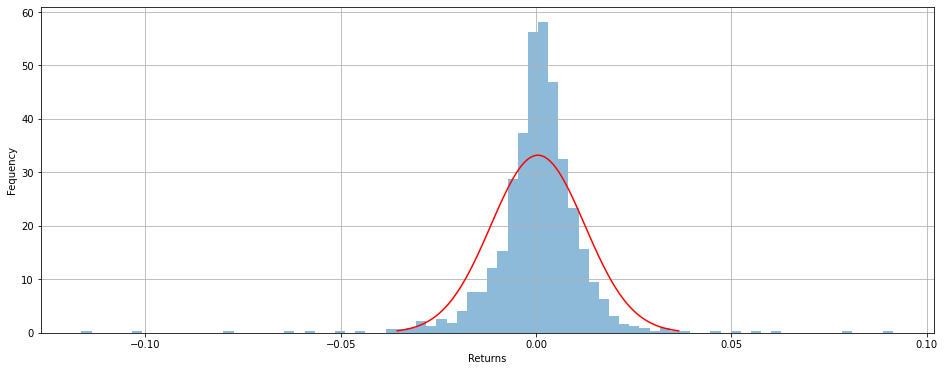

In [ ]:
# ticker = yf.Ticker("VT")
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [16, 6]
a=ticker.history( period='250wk', interval='1d' )[['Close']]
df=a['Close'].pct_change()
df = df.dropna()
mean = np.mean(df)
std_dev = np.std(df)
df.hist(bins=80, histtype='stepfilled', alpha=0.5, density=True,  )
x = np.linspace( mean - 3*std_dev, mean + 3*std_dev, 100)
plt.plot(x, norm.pdf(x, mean, std_dev), "r")
plt.xlabel('Returns')
plt.ylabel('Fequency')
plt.show()

In [ ]:
VaR_90 = round(norm.ppf(1-0.9, mean, std_dev)*100,2)
VaR_95 = round(norm.ppf(1-0.95, mean, std_dev)*100,2)
VaR_99= round(norm.ppf(1-0.99, mean, std_dev)*100,2)
pd.DataFrame([['90%', str(VaR_90)+'%'], ['95%', str(VaR_95)+'%'], ["99%", str(VaR_99)+'%']], columns=['Confidence Level', 'Value at Risk'])


,Confidence Level,Value at Risk
0,90%,-1.39%
1,95%,-1.8%
2,99%,-2.56%


In [ ]:
a=ticker.history(interval='1d', period='4wk')['Close']
a.std()/a.median()

0.04631354645991305

In [ ]:
a/a[0]-1

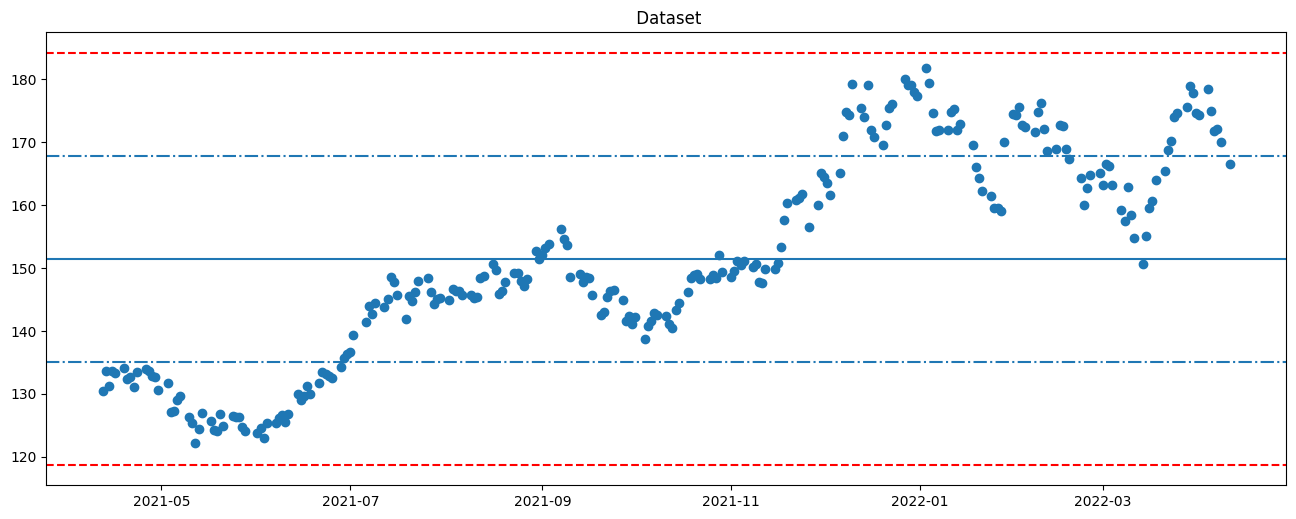

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# a=ticker.history( period='52wk', interval='1d' )[['High','Low']]

ticker2 = yf.Ticker('AAPL') 
# ticker2 = yf.Ticker('TSLA') 
a=ticker2.history( period='52wk', interval='1d' )[['Close']]

plt.title(" Dataset")
# plt.ylim(min(a['Close']) - 50, max(a['Close']) + 20)
plt.scatter(x=a.index, y=a['Close'])
# plt.scatter(x=a.index, y=a['Low'])
plt.axhline(y=a['Close'].mean(), xmin=0, xmax=1,  )
# plt.axhline(y=a['Low'].mean(), xmin=0, xmax=1, color='r'  )

plt.axhline(y=a['Close'].mean()+a['Close'].std(), xmin=0, xmax=1, ls='-.' )
# plt.axhline(y=a['Low'].mean()+a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.'  )
plt.axhline(y=a['Close'].mean()-a['Close'].std(), xmin=0, xmax=1, ls='-.')
# plt.axhline(y=a['Low'].mean()-a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.' )

plt.axhline(y=a['Close'].mean()+2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r')
# plt.axhline(y=a['Low'].mean()+2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--' )
plt.axhline(y=a['Close'].mean()-2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r'  )
# plt.axhline(y=a['Low'].mean()-2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--'  )

# plt.axhline(y=a['Close'].mean()+3*a['Close'].std(), xmin=0, xmax=1  )
# plt.axhline(y=a['Close'].mean()-3*a['Close'].std(), xmin=0, xmax=1, color='r' )

plt.show()



In [ ]:
 ' '.join([prop for prop in ticker.info ])

'zip sector fullTimeEmployees longBusinessSummary city phone state country companyOfficers website maxAge address1 industry ebitdaMargins profitMargins grossMargins operatingCashflow revenueGrowth operatingMargins ebitda targetLowPrice recommendationKey grossProfits freeCashflow targetMedianPrice currentPrice earningsGrowth currentRatio returnOnAssets numberOfAnalystOpinions targetMeanPrice debtToEquity returnOnEquity targetHighPrice totalCash totalDebt totalRevenue totalCashPerShare financialCurrency revenuePerShare quickRatio recommendationMean exchange shortName longName exchangeTimezoneName exchangeTimezoneShortName isEsgPopulated gmtOffSetMilliseconds quoteType symbol messageBoardId market annualHoldingsTurnover enterpriseToRevenue beta3Year enterpriseToEbitda 52WeekChange morningStarRiskRating forwardEps revenueQuarterlyGrowth sharesOutstanding fundInceptionDate annualReportExpenseRatio totalAssets bookValue sharesShort sharesPercentSharesOut fundFamily lastFiscalYearEnd heldPerc

,Confidence Level,Value at Risk
0,90%,-0.023906
1,95%,-0.031109
2,99%,-0.044622


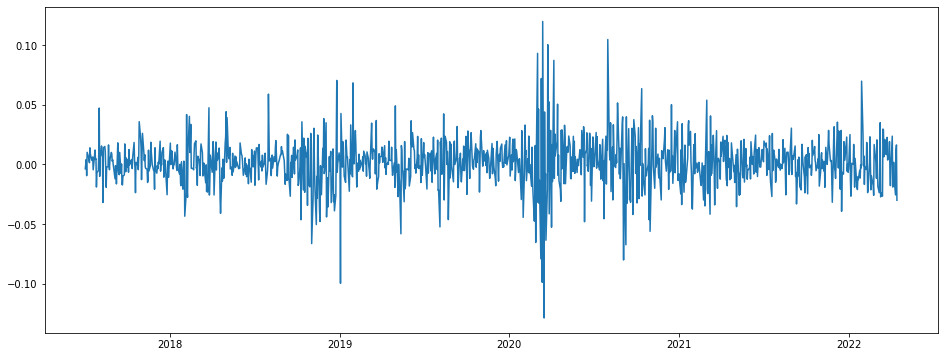

In [ ]:
# a.mean()
# plt.plot(a.diff())
plt.plot(a.pct_change())

In [ ]:
a=ticker.history( period='52wk', interval='1d' )[['Close']]
a['abs_change'] = a.diff()
a['pct_change'] = a['Close'].pct_change()
a.std()


Close         3.863167
abs_change    0.845467
pct_change    0.016352
dtype: float64

In [ ]:
round(a['Close'].pct_change().std()*np.sqrt(365)*100,2)

31.24

In [ ]:
ticker2 = yf.Ticker('TSLA') 

b=ticker2.history( interval='1d', start='2020-03-01', end='2021-03-01' )[['Close']]
round(b['Close'].pct_change().std()*np.sqrt(365)*100,2)
# len(b['Close']) = 254 !


100.58

In [ ]:
ticker2.get_info().get('beta')
# cc=ticker.history( period='52wk', interval='1d' )[['Close']]
# cc.pct_change().values

2.079411